## Updates
- Pytesseract attempt (done 23/6/2023)
- [Perspective Transformation (perspective)](https://towardsdatascience.com/perspective-versus-affine-transformation-25033cef5766) (done 27/6/2023)
- update codebase for ocrimg and dashboard
- further generalize and automate the image preprocessing

- take note of python version, environment variables

In [1]:
import cv2
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imutils
from sklearn.metrics import euclidean_distances
from scipy import ndimage

In [2]:
# indicate the document height and width
doc_w, doc_h = 1098, 648

In [43]:
#helper code
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

def greyscale(src):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    return gray

def normalize(src):
    norm_img = np.zeros((src.shape[0], src.shape[1]))
    img = cv2.normalize(src, norm_img, 0, 255, cv2.NORM_MINMAX)
    return img

def deskew(src):
    co_ords = np.column_stack(np.where(src > 0))
    angle = cv2.minAreaRect(co_ords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = src.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(src, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def contrast_enhance(src):
    return cv2.equalizeHist(src)

def remove_noise(src):
    return cv2.fastNlMeansDenoisingColored(src, None, 10, 10, 7, 15)

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def thresholding(src):
    return cv2.threshold(src, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) [1]

def sobel_filters(src):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(src, Kx)
    Iy = ndimage.filters.convolve(src, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

def non_max_suppression(src, D):
    '''makes edges dected in the canny image thinner'''
    M, N = src.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = src[i, j+1]
                    r = src[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = src[i+1, j-1]
                    r = src[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = src[i+1, j]
                    r = src[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = src[i-1, j-1]
                    r = src[i+1, j+1]

                if (src[i,j] >= q) and (src[i,j] >= r):
                    Z[i,j] = src[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

def threshold(src, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    '''captures both weak and strong edges using a double threshold'''
    
    highThreshold = src.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = src.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(src >= highThreshold)
    zeros_i, zeros_j = np.where(src < lowThreshold)
    
    weak_i, weak_j = np.where((src <= highThreshold) & (src >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def adaptative_threshold(src):
    '''obtain binary thresholded image of blurred image'''
    mask = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 10)
    return mask

def bimodal_threshold(src):
    _, thres = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return thres

def hysteresis(src, weak, strong=255):
    '''contrast between weak and strong pixels is increased'''
    M, N = src.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (src[i,j] == weak):
                try:
                    if ((src[i+1, j-1] == strong) or (src[i+1, j] == strong) or (src[i+1, j+1] == strong)
                        or (src[i, j-1] == strong) or (src[i, j+1] == strong)
                        or (src[i-1, j-1] == strong) or (src[i-1, j] == strong) or (src[i-1, j+1] == strong)):
                        src[i, j] = strong
                    else:
                        src[i, j] = 0
                except IndexError as e:
                    pass
    return src

def get_edges(img):
    '''input an image opened by invoking cv2.imread.
        output the same image reduced to its edges.'''
    # convert the image to grayscale, blur it, and find edges
    # in the image
    #gray = cv2.cvtColor(gammaCorrection(img, 1.05), cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(img, (5, 5), 0)
    edged = cv2.Canny(gray, 70, 150)
    
    # show the original image and the edge detected image
    #plt.imshow(edged)
    
    return edged

In [45]:
test_path = "./Images/20230704_151059.jpg"
img = cv2.imread(test_path)
gray = greyscale(img)
contrast = contrast_enhance(gray)
edged = get_edges(contrast)
thres = adaptative_threshold(contrast)

cv2.namedWindow("normal", cv2.WINDOW_NORMAL)
cv2.namedWindow("grayscale", cv2.WINDOW_NORMAL)
cv2.namedWindow("contrasted", cv2.WINDOW_NORMAL)
cv2.namedWindow("thresholded", cv2.WINDOW_NORMAL)
cv2.imshow("normal", img)
cv2.imshow("grayscale", gray)
cv2.imshow("contrasted", contrast)
cv2.imshow("thresholded", thres)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def get_all_boxes(edged):
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points, then we
		# can assume that we have found our screen
		if len(approx) >= 4:
			screenCnt = approx
			break

	return screenCnt

In [9]:
def transform_image(img):
    
    transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
    out = cv2.warpPerspective(img, transform_mat, (max_w, max_h), flags=cv2.INTER_LINEAR)
    
    return out

## Regex and stuff

In [10]:
import regex as re
import json

def extract_text(img_path, lang):
    return pytesseract.image_to_string(Image.open(img_path), lang = lang)

def extract_name(ocr_result):
    # Define pattern to extract company
    company_pattern = r'(?i)(?:^|\b)([A-Z][A-Za-z]+(?: [A-Z][A-Za-z]+)*)(?:\b|$)'

    # Extract company using regular expression pattern
    company_match = re.search(company_pattern, ocr_result)
    if company_match:
        return company_match.group(1)
    else:
        return None

def extract_email(ocr_result):
    # Extract email address using regular expression pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    email_match = re.search(email_pattern, ocr_result, re.I)
    if email_match:
        return email_match.group()
    else:
        return None

def extract_company(ocr_result):
    # Define pattern to extract company
    company_pattern = r'(?i)(?:^|\b)([A-Z][A-Za-z]+(?: [A-Z][A-Za-z]+)*)(?:\b|$)'

    # Extract company using regular expression pattern
    company_match = re.search(company_pattern, ocr_result)
    if company_match:
        return company_match.group(1)
    else:
        return None

def extract_contact(ocr_result):
    # Extract contact number using regular expression pattern
    contact_number_pattern = r'\b\d+\b'
    contact_number_matches = re.findall(contact_number_pattern, ocr_result)
    contact_number = ''.join(contact_number_matches)
    if contact_number:
        return contact_number
    else:
        return None

# function to produce the json
def extract_json(img_path, lang):
    res_dict = {}
    
    extracted_txt = extract_text(img_path, lang = lang)
    res_dict["name"], res_dict["email"], res_dict["contact"], res_dict["company"] = extract_name(extracted_txt), extract_email(extracted_txt), extract_contact(extracted_txt), extract_contact(extracted_txt)
    
    res_json = json.dumps(res_dict)
    return res_json


## Driver code

This is the test case. We will be conducting the following:

- Evaluate the accuracy of the edge detection performed, in this case we have only tried Canny Edge Detection without any Thresholding
- Show the final output of performing OCR on the card.

The best model will be transferred to the deployment phase.

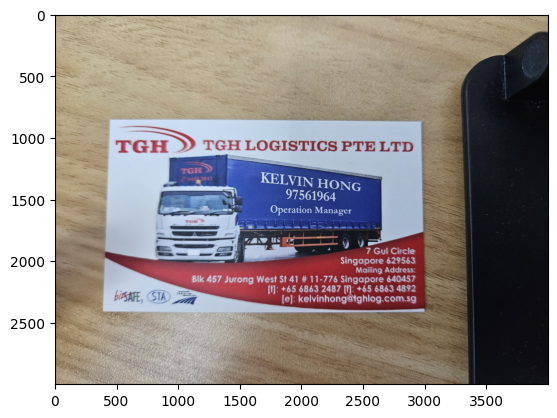

In [13]:
test_path = "./Images/20230704_151104.jpg"
img = cv2.imread(test_path)

# Convert BGR image to RGB for plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

[0 0] [665   0] [  0 499] [559 498]


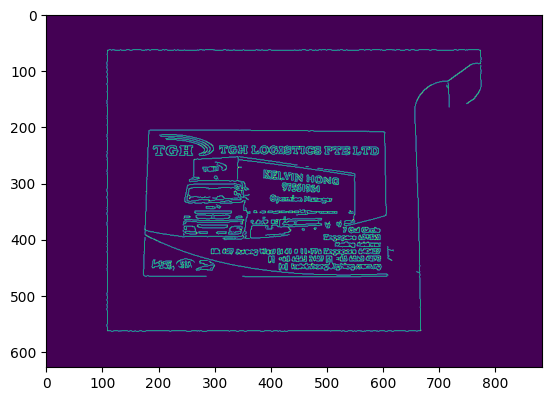

In [14]:
#test the accuracy of the bounding boxes
from pytesseract import Output

#new_img = transform_image(cv2.resize(img, dsize = (doc_w, doc_h), interpolation=cv2.INTER_LINEAR))
new_img = transform_image(imutils.resize(img, height = 500))

#pytesseract.image_to_string(new_img)
h, w, c = new_img.shape
words = pytesseract.image_to_data(new_img, output_type=Output.DICT) 

n_boxes = len(words['level'])
for i in range(n_boxes):
    (x, y, w, h) = (words['left'][i], words['top'][i], words['width'][i], words['height'][i])
    cv2.rectangle(new_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# testing the json function
#extract_json(test_path, "eng")

cv2.imshow("Test case", new_img)
cv2.waitKey(0)
cv2.destroyAllWindows()